In [683]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import math

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras import initializers

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import xgboost as xgb
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV



#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [684]:
def quartersToHours(data):
    data['date_forecast'] = pd.to_datetime(data['date_forecast'], format='%Y-%m.%d %H:%M:%S')
    data["year"] = data['date_forecast'].dt.year
    data["month"] = data['date_forecast'].dt.month
    data["day"] = data['date_forecast'].dt.day
    data["hour"] = data['date_forecast'].dt.hour


    group = data.groupby([data["year"], data["month"], data["day"], data["hour"]])  
    result = group.mean()
    result = result.reset_index()
    
    return_df = result.drop(['year','month', 'day', 'hour'], axis=1)
    
    return return_df

In [685]:
def join_data_and_labels(train, val, labels):
    
    #Remove hour and minute values
    val = val.assign(date_forecast=val.date_forecast.dt.round('H'))
    train = train.assign(date_forecast=train.date_forecast.dt.round('H'))
    
    #rename columns names to match
    
    train = train.rename(columns={'date_forecast': 'date'})
    val = val.rename(columns={'date_forecast': 'date'})
    labels = labels.rename(columns={'time': 'date'})
    
    joined_train = pd.merge(train, labels, how="inner", on="date")
    joined_val = pd.merge(val, labels, how="inner", on="date")

    
    return joined_train, joined_val

In [686]:
def remove_unused_columns(df):
    df = df.drop(['relative_humidity_1000hPa:p', 'air_density_2m:kgm3', 'is_in_shadow:idx',
                 'fresh_snow_12h:cm','fresh_snow_6h:cm', 'fresh_snow_3h:cm', 'fresh_snow_24h:cm',
                 'wind_speed_10m:ms', 'elevation:m', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
                 'wind_speed_w_1000hPa:ms', 'effective_cloud_cover:p', 'total_cloud_cover:p',
                 'super_cooled_liquid_water:kgm2' , 'snow_water:kgm2', 'rain_water:kgm2', 'precip_5min:mm', 
                  'precip_type_5min:idx', 'fresh_snow_1h:cm', 'absolute_humidity_2m:gm3'], axis=1)
    return df



# 'absolute_humidity_2m:gm3', 

In [687]:
def drop_constanst_columns(train, val, test):
    constanst_columns = []
    # Remove constants
    for key, value in test.std().items():
        if value == 0.0:
            constanst_columns.append(key)

    train.drop(constanst_columns, axis=1,inplace=True)
    val.drop(constanst_columns, axis=1,inplace=True)
    test.drop(constanst_columns, axis=1,inplace=True)

In [688]:
def convert_date_to_sin_and_cos(df):
    day = 24*60*60 #seconds in a day
    year = (365.2425)*day #seconds in a year
    month = year / 12.0

    date_time = pd.to_datetime(df.pop('date'), format='%Y-%m.%d %H:%M:%S')
    
    timestamp_s = date_time.map(pd.Timestamp.timestamp)

    #df['Month sin'] = np.sin(timestamp_s * (2 * np.pi / month))
    #df['Month cos'] = np.cos(timestamp_s * (2 * np.pi / month))
    
    df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    
    df['Hour sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Hour cos'] = np.cos(timestamp_s * (2 * np.pi / day))
   

In [689]:
def round_is_day(df):
    df["is_day:idx"] = [round(df["is_day:idx"][i]) for i in range(len(df))]
    #df["is_in_shadow:idx"] = [round(df["is_in_shadow:idx"][i]) for i in range(len(df))]
    

In [690]:
def normalize_except_columns(df):
    not_to_be_norm = ["is_day:idx", 'is_in_shadow:idx', 'Hour sin', 'Hour cos',"Year sin", "Year cos"]
    cols = df.columns.tolist()
    cols_to_norm = [i for i in cols if i not in not_to_be_norm]
    
    df[cols_to_norm] = df[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))


In [691]:
train_a = pd.read_parquet('dataset/A/train_targets.parquet')
train_b = pd.read_parquet('dataset/B/train_targets.parquet')
train_c = pd.read_parquet('dataset/C/train_targets.parquet')

In [692]:
a_max = train_a["pv_measurement"].max()
b_max = train_b["pv_measurement"].max()
c_max = train_c["pv_measurement"].max()

In [693]:
#Load data, sample to hours and drop columns which are not needed
X_train_observed_a = quartersToHours(pd.read_parquet('dataset/A/X_train_observed.parquet')) #Train_x
X_train_observed_b = quartersToHours(pd.read_parquet('dataset/B/X_train_observed.parquet'))
X_train_observed_c = quartersToHours(pd.read_parquet('dataset/C/X_train_observed.parquet'))

X_train_estimated_a = quartersToHours(pd.read_parquet('dataset/A/X_train_estimated.parquet')) # Val_x
X_train_estimated_a = X_train_estimated_a.drop(["date_calc"], axis=1)

X_train_estimated_b = quartersToHours(pd.read_parquet('dataset/B/X_train_estimated.parquet'))
X_train_estimated_b = X_train_estimated_b.drop(["date_calc"], axis=1)

X_train_estimated_c = quartersToHours(pd.read_parquet('dataset/C/X_train_estimated.parquet'))
X_train_estimated_c = X_train_estimated_c.drop(["date_calc"], axis=1)

X_test_estimated_a = quartersToHours(pd.read_parquet('dataset/A/X_test_estimated.parquet'))
X_test_estimated_a = X_test_estimated_a.drop(["date_calc"], axis=1)
test_a = X_test_estimated_a.rename(columns={'date_forecast': 'date'})

X_test_estimated_b = quartersToHours(pd.read_parquet('dataset/B/X_test_estimated.parquet'))
X_test_estimated_b = X_test_estimated_b.drop(["date_calc"], axis=1)
test_b = X_test_estimated_b.rename(columns={'date_forecast': 'date'})

X_test_estimated_c = quartersToHours(pd.read_parquet('dataset/C/X_test_estimated.parquet'))
X_test_estimated_c = X_test_estimated_c.drop(["date_calc"], axis=1)
test_c = X_test_estimated_c.rename(columns={'date_forecast': 'date'})

In [694]:
# Join data and labels into one df
train_data_a, val_data_a = join_data_and_labels(X_train_observed_a, X_train_estimated_a, train_a)
train_data_b, val_data_b = join_data_and_labels(X_train_observed_b, X_train_estimated_b, train_b)
train_data_c, val_data_c = join_data_and_labels(X_train_observed_c, X_train_estimated_c, train_c)

In [695]:
# Remove columns which are not needed
#train_data_a = remove_unused_columns(train_data_a)
#val_data_a = remove_unused_columns(val_data_a)
#test_a = remove_unused_columns(test_a)

#train_data_b = remove_unused_columns(train_data_b)
#val_data_b = remove_unused_columns(val_data_b)
#test_b = remove_unused_columns(test_b)

#train_data_c = remove_unused_columns(train_data_c)
#val_data_c = remove_unused_columns(val_data_c)
#test_c = remove_unused_columns(test_c)

In [696]:
#Convert date into sin and cos components
#convert_date_to_sin_and_cos(train_data_a)
#convert_date_to_sin_and_cos(val_data_a)
#convert_date_to_sin_and_cos(test_a)

#convert_date_to_sin_and_cos(train_data_b)
#convert_date_to_sin_and_cos(val_data_b)
#convert_date_to_sin_and_cos(test_b)

#convert_date_to_sin_and_cos(train_data_c)
#convert_date_to_sin_and_cos(val_data_c)
#convert_date_to_sin_and_cos(test_c)

train_data_a["month"] = [train_data_a["date"][i].month for i in range(len(train_data_a))]
train_data_a["hour"] = [train_data_a["date"][i].hour for i in range(len(train_data_a))]
train_data_a.pop('date')

val_data_a["month"] = [val_data_a["date"][i].month for i in range(len(val_data_a))]
val_data_a["hour"] = [val_data_a["date"][i].hour for i in range(len(val_data_a))]
val_data_a.pop('date')

test_a["month"] = [test_a["date"][i].month for i in range(len(test_a))]
test_a["hour"] = [test_a["date"][i].hour for i in range(len(test_a))]
test_a.pop('date')

0     2023-05-01 00:22:30
1     2023-05-01 01:22:30
2     2023-05-01 02:22:30
3     2023-05-01 03:22:30
4     2023-05-01 04:22:30
              ...        
715   2023-07-03 19:22:30
716   2023-07-03 20:22:30
717   2023-07-03 21:22:30
718   2023-07-03 22:22:30
719   2023-07-03 23:22:30
Name: date, Length: 720, dtype: datetime64[ns]

In [697]:
# Isday should be a binary value
round_is_day(train_data_a)
round_is_day(val_data_a)
round_is_day(test_a)

round_is_day(train_data_b)
round_is_day(val_data_b)
round_is_day(test_b)

round_is_day(train_data_c)
round_is_day(val_data_c)
round_is_day(test_c)

In [698]:
#normalize_except_columns(train_data_a)
#normalize_except_columns(val_data_a)
#normalize_except_columns(test_a)

#normalize_except_columns(train_data_b)
#normalize_except_columns(val_data_b)
#normalize_except_columns(test_b)

#normalize_except_columns(train_data_c)
#normalize_except_columns(val_data_c)
#normalize_except_columns(test_c)

In [699]:
# Fill 0 for NaNs
train_data_a = train_data_a.fillna(0)
val_data_a = val_data_a.fillna(0)
test_a = test_a.fillna(0)

train_data_b = train_data_b.fillna(0)
val_data_b = val_data_b.fillna(0)
test_b = test_b.fillna(0)

train_data_c = train_data_c.fillna(0)
val_data_c = val_data_c.fillna(0)
test_c = test_c.fillna(0)

In [700]:
# Drop columns which are constant
drop_constanst_columns(train_data_a, val_data_a, test_a)
drop_constanst_columns(train_data_b, val_data_b, test_b)
drop_constanst_columns(train_data_c, val_data_c, test_c)

In [701]:
train_data_c = train_data_c[5800:]
train_data_b.drop(index=train_data_b.iloc[13410:14460].index.tolist(), axis=0, inplace=True)

In [702]:
train_data_a.describe().transpose() 

,count,mean,std,min,25%,50%,75%,max
absolute_humidity_2m:gm3,29667.0,6.652590,2.795389,0.700000,4.450000,6.300000,8.600000e+00,1.735000e+01
air_density_2m:kgm3,29667.0,1.249064,0.036304,1.145000,1.224500,1.246500,1.272500e+00,1.426250e+00
ceiling_height_agl:m,29667.0,2417.717041,2587.791504,0.000000,608.149994,1525.199951,3.333950e+03,1.228565e+04
clear_sky_energy_1h:J,29667.0,599406.750000,877458.937500,0.000000,0.000000,41072.101562,1.025277e+06,2.988628e+06
clear_sky_rad:W,29667.0,166.501816,244.360016,0.000000,0.000000,9.925000,2.917375e+02,8.351000e+02
cloud_base_agl:m,29667.0,1639.017578,1810.996338,0.000000,503.399994,1078.849976,2.003925e+03,1.167362e+04
dew_or_rime:idx,29667.0,0.022399,0.180998,-1.000000,0.000000,0.000000,0.000000e+00,1.000000e+00
dew_point_2m:K,29667.0,276.823364,6.700175,251.074997,272.075012,277.150024,2.819500e+02,2.936250e+02
diffuse_rad:W,29667.0,44.918659,64.518402,0.000000,0.000000,4.750000,7.627500e+01,3.322750e+02
diffuse_rad_1h:J,29667.0,161707.031250,229471.187500,0.000000,0.000000,26047.175781,2.739763e+05,1.191085e+06


<Axes: >

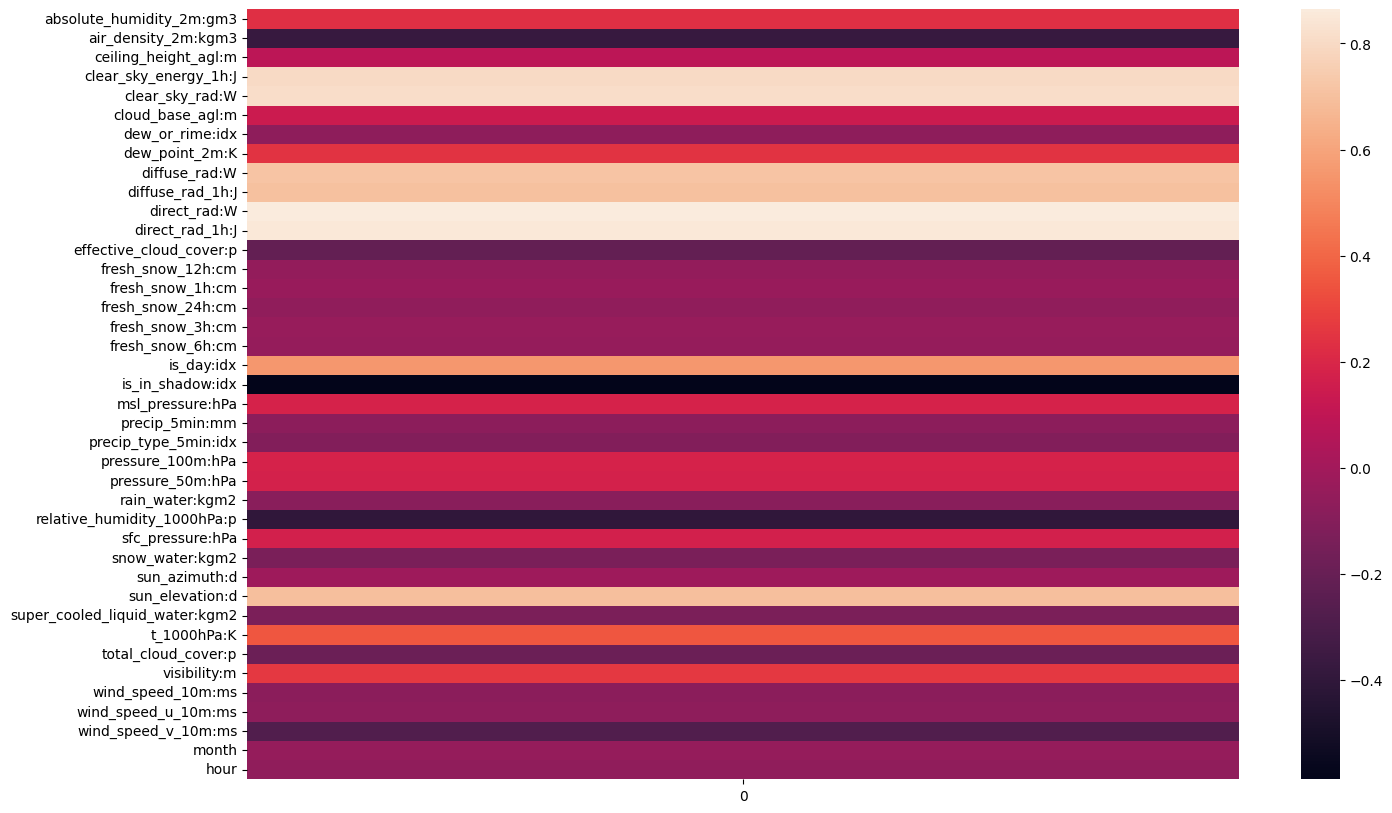

In [703]:
#corr = train_data_a.corrwith()

plt.figure(figsize=(16,10))
corr_with_target = train_data_a.drop(columns='pv_measurement').corrwith(train_data_a['pv_measurement'])
sns.heatmap(pd.DataFrame(corr_with_target))



In [704]:
train_a_y = train_data_a.pop("pv_measurement")
val_a_y = val_data_a.pop("pv_measurement")

train_b_y = train_data_b.pop("pv_measurement")
val_b_y = val_data_b.pop("pv_measurement")

train_c_y = train_data_c.pop("pv_measurement")
val_c_y = val_data_c.pop("pv_measurement")

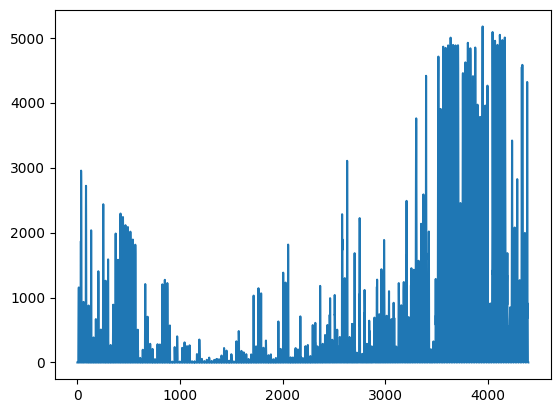

In [705]:
plt.plot(val_a_y)

In [706]:
#scaler_train_a = StandardScaler()
#train_data_a = scaler_train_a.fit_transform(train_data_a)

#scaler_val_a = StandardScaler()
#val_data_a = scaler_val_a.fit_transform(val_data_a)

In [707]:
le = LabelEncoder()
train_a_y = le.fit_transform(train_a_y)

le_2 = LabelEncoder()
val_a_y = le_2.fit_transform(val_a_y)

In [722]:
def modelfit(alg, xs, ys, val_xs, val_ys, useTrainCV=True, cv_folds=5, early_stopping_rounds=10):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(xs, label=ys)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds, 
                          early_stopping_rounds=early_stopping_rounds, verbose_eval =True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(xs, ys, eval_set=[(xs, ys),(val_xs, val_ys)], verbose=True)
        
    #Predict training set:
    dtrain_predictions = alg.predict(xs)
    dval_predictions = alg.predict(val_xs)
    
    mae = mean_absolute_error(dtrain_predictions, ys)
    mae_val = mean_absolute_error(dval_predictions, val_ys)
    print(mae, mae_val)
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [709]:
import gc
gc.collect()

8747

[0]	train-mae:1487.80016+5.98919	test-mae:1487.99801+30.09180
[1]	train-mae:1252.94219+4.50434	test-mae:1253.78417+27.35369
[2]	train-mae:1063.49381+1.89456	test-mae:1066.05868+26.87911
[3]	train-mae:907.96581+4.54483	test-mae:911.27814+20.27293
[4]	train-mae:787.76634+5.74829	test-mae:792.08819+18.12280
[5]	train-mae:697.06251+4.75793	test-mae:701.40121+16.66941
[6]	train-mae:624.90034+3.83194	test-mae:630.62927+14.75032
[7]	train-mae:573.21682+3.92255	test-mae:579.36926+13.61456
[8]	train-mae:533.35030+2.53728	test-mae:540.15346+11.61815
[9]	train-mae:502.93090+2.24858	test-mae:510.02616+10.12501
[10]	train-mae:480.28067+1.81091	test-mae:487.55773+9.03352
[11]	train-mae:462.13078+2.05844	test-mae:469.85048+7.78705
[12]	train-mae:448.49813+1.36035	test-mae:456.92533+7.75331
[13]	train-mae:438.70426+1.91473	test-mae:447.48686+7.06837
[14]	train-mae:429.93526+1.66434	test-mae:438.85096+6.56685
[15]	train-mae:423.56555+1.59517	test-mae:432.78267+5.68721
[16]	train-mae:418.34314+1.82247	t

[136]	train-mae:359.97632+0.77415	test-mae:383.15058+4.79869
[137]	train-mae:359.85315+0.71967	test-mae:383.05504+4.83476
[138]	train-mae:359.74143+0.66446	test-mae:382.99489+4.89369
[139]	train-mae:359.63733+0.65562	test-mae:382.94391+4.90801
[140]	train-mae:359.60141+0.64946	test-mae:382.93780+4.91080
[141]	train-mae:359.55805+0.69827	test-mae:382.93039+4.92229
[142]	train-mae:359.50936+0.70432	test-mae:382.92211+4.94898
[143]	train-mae:359.44483+0.71901	test-mae:382.91113+4.95270
[144]	train-mae:359.40902+0.73991	test-mae:382.89261+4.96763
[145]	train-mae:359.35781+0.76485	test-mae:382.85577+4.96749
[146]	train-mae:359.27625+0.80404	test-mae:382.85960+4.96126
[147]	train-mae:359.15989+0.82165	test-mae:382.80447+4.92922
[148]	train-mae:359.13103+0.83779	test-mae:382.81050+4.92711
[149]	train-mae:359.10461+0.86864	test-mae:382.80032+4.91638
[150]	train-mae:359.03534+0.86987	test-mae:382.72577+4.95343
[151]	train-mae:358.95138+0.83534	test-mae:382.67871+4.96375
[152]	train-mae:358.8042

[271]	train-mae:351.93344+1.14598	test-mae:380.01276+4.97178
[272]	train-mae:351.87398+1.09703	test-mae:380.00741+5.00354
[273]	train-mae:351.84159+1.07945	test-mae:380.00060+5.00817
[274]	train-mae:351.75457+1.08553	test-mae:379.95144+4.99078
[275]	train-mae:351.69551+1.06636	test-mae:379.93933+5.00643
[276]	train-mae:351.63478+1.07633	test-mae:379.89167+5.01554
[277]	train-mae:351.63156+1.07233	test-mae:379.88895+5.01200
[278]	train-mae:351.59107+1.06290	test-mae:379.86461+5.02619
[279]	train-mae:351.53492+1.02108	test-mae:379.84186+5.00319
[280]	train-mae:351.53489+1.02106	test-mae:379.84192+5.00318
[281]	train-mae:351.50697+1.03086	test-mae:379.82618+5.00856
[282]	train-mae:351.45794+1.03406	test-mae:379.79688+5.05070
[283]	train-mae:351.43479+1.03600	test-mae:379.79804+5.03657
[284]	train-mae:351.42191+1.02817	test-mae:379.79659+5.03768
[285]	train-mae:351.37972+1.05847	test-mae:379.80408+5.01842
[286]	train-mae:351.36822+1.07054	test-mae:379.81377+5.01480
[287]	train-mae:351.3464

[406]	train-mae:348.10361+0.72496	test-mae:378.43824+5.04458
[407]	train-mae:348.07997+0.71388	test-mae:378.41349+5.01764
[408]	train-mae:348.04940+0.72672	test-mae:378.41874+5.01935
[409]	train-mae:348.00535+0.75786	test-mae:378.40572+5.00678
[410]	train-mae:347.97730+0.77145	test-mae:378.38437+5.00375
[411]	train-mae:347.95706+0.79371	test-mae:378.36453+4.98997
[412]	train-mae:347.91920+0.79538	test-mae:378.34600+4.96939
[413]	train-mae:347.91917+0.79537	test-mae:378.34608+4.96945
[414]	train-mae:347.90235+0.81436	test-mae:378.33512+4.97241
[415]	train-mae:347.89864+0.81869	test-mae:378.33748+4.97189
[416]	train-mae:347.88194+0.81631	test-mae:378.33563+4.96861
[417]	train-mae:347.85794+0.81002	test-mae:378.32636+4.97409
[418]	train-mae:347.83254+0.82627	test-mae:378.32398+4.97219
[419]	train-mae:347.82922+0.82334	test-mae:378.32265+4.97337
[420]	train-mae:347.80177+0.81701	test-mae:378.31922+4.98027
[421]	train-mae:347.78092+0.81110	test-mae:378.31448+4.97039
[422]	train-mae:347.7682

[64]	validation_0-mae:371.90466	validation_1-mae:679.14159
[65]	validation_0-mae:371.57186	validation_1-mae:679.00196
[66]	validation_0-mae:371.13191	validation_1-mae:677.54768
[67]	validation_0-mae:371.01760	validation_1-mae:678.15983
[68]	validation_0-mae:370.79455	validation_1-mae:678.28953
[69]	validation_0-mae:370.39503	validation_1-mae:679.40978
[70]	validation_0-mae:370.04325	validation_1-mae:680.58115
[71]	validation_0-mae:369.50914	validation_1-mae:681.44947
[72]	validation_0-mae:368.96486	validation_1-mae:681.32340
[73]	validation_0-mae:368.54344	validation_1-mae:681.52859
[74]	validation_0-mae:368.42302	validation_1-mae:681.80249
[75]	validation_0-mae:368.14365	validation_1-mae:681.94144
[76]	validation_0-mae:367.98771	validation_1-mae:682.13926
[77]	validation_0-mae:367.66819	validation_1-mae:682.36731
[78]	validation_0-mae:366.98501	validation_1-mae:681.54303
[79]	validation_0-mae:366.47123	validation_1-mae:682.71420
[80]	validation_0-mae:366.34583	validation_1-mae:683.122

[202]	validation_0-mae:353.55310	validation_1-mae:682.64722
[203]	validation_0-mae:353.46556	validation_1-mae:682.58296
[204]	validation_0-mae:353.41847	validation_1-mae:682.48488
[205]	validation_0-mae:353.09299	validation_1-mae:682.62518
[206]	validation_0-mae:352.94240	validation_1-mae:682.85026
[207]	validation_0-mae:352.90232	validation_1-mae:682.99438
[208]	validation_0-mae:352.81329	validation_1-mae:682.79046
[209]	validation_0-mae:352.76971	validation_1-mae:682.81303
[210]	validation_0-mae:352.74485	validation_1-mae:683.14382
[211]	validation_0-mae:352.74485	validation_1-mae:683.14233
[212]	validation_0-mae:352.70989	validation_1-mae:683.09049
[213]	validation_0-mae:352.67662	validation_1-mae:683.13323
[214]	validation_0-mae:352.67662	validation_1-mae:683.14268
[215]	validation_0-mae:352.60983	validation_1-mae:683.64438
[216]	validation_0-mae:352.53482	validation_1-mae:683.80870
[217]	validation_0-mae:352.53481	validation_1-mae:683.80695
[218]	validation_0-mae:352.53481	validat

[339]	validation_0-mae:347.23854	validation_1-mae:682.62589
[340]	validation_0-mae:347.15691	validation_1-mae:682.86097
[341]	validation_0-mae:347.09449	validation_1-mae:682.80418
[342]	validation_0-mae:347.09449	validation_1-mae:682.80466
[343]	validation_0-mae:346.91111	validation_1-mae:682.66333
[344]	validation_0-mae:346.83879	validation_1-mae:682.41076
[345]	validation_0-mae:346.81622	validation_1-mae:682.45613
[346]	validation_0-mae:346.81624	validation_1-mae:682.46467
[347]	validation_0-mae:346.81622	validation_1-mae:682.45297
[348]	validation_0-mae:346.77662	validation_1-mae:682.50159
[349]	validation_0-mae:346.67561	validation_1-mae:682.30951
[350]	validation_0-mae:346.61993	validation_1-mae:682.91702
[351]	validation_0-mae:346.61993	validation_1-mae:682.91345
[352]	validation_0-mae:346.54553	validation_1-mae:682.20033
[353]	validation_0-mae:346.50282	validation_1-mae:682.30200
[354]	validation_0-mae:346.36368	validation_1-mae:682.73530
[355]	validation_0-mae:346.36369	validat

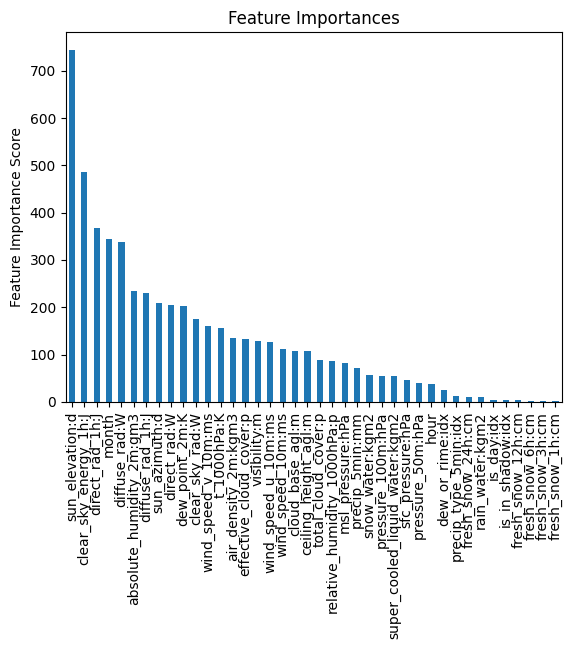

In [745]:
xgb1 = xgb.XGBRegressor(
 device='cuda',
 learning_rate =0.2,
 n_estimators=2000,
 max_depth=5,
 min_child_weight=2,
 gamma=0.0,
 reg_alpha=96,
 subsample=0.9,
 colsample_bytree=0.85,
 objective= 'reg:absoluteerror',
 nthread=4,
 seed=42,
 eval_metric= 'mae',
 booster='gbtree'
)

modelfit(xgb1, train_data_a, train_a_y, val_data_a, val_a_y, useTrainCV = True)
#modelfit(xgb1, train_data_a, train_a_y, useTrainCV=False)
#modelfit_core(params, train_data_a, train_a_y, val_data_a, val_a_y, useTrainCV=True, n_boost=1000)

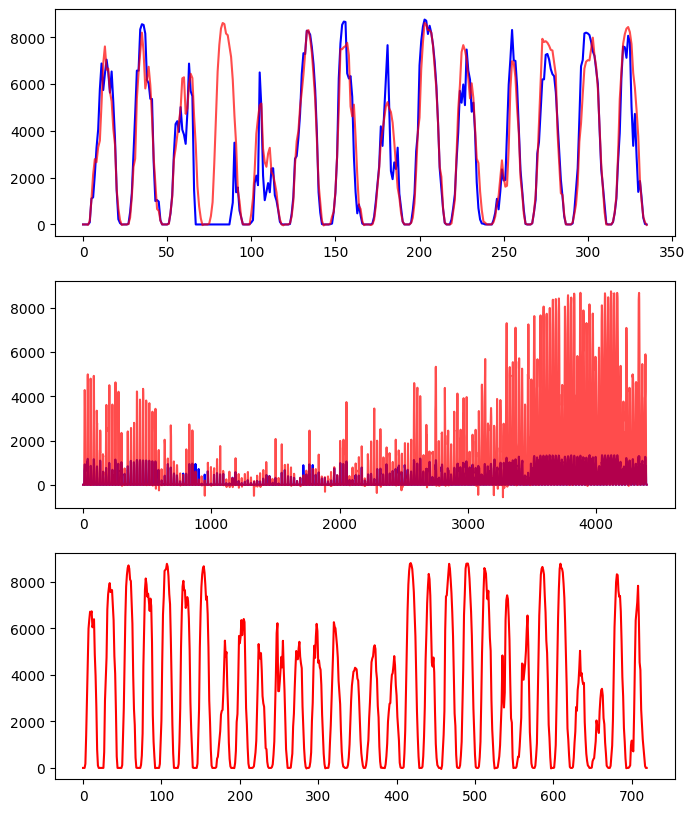

In [746]:
preds_train = xgb1.predict(train_data_a)
preds_val = xgb1.predict(val_data_a)
pred_test = xgb1.predict(test_a)
fig, axs = plt.subplots(3, figsize=(8, 10))
axs[0].plot(train_a_y[0:24*14], color="blue")
axs[0].plot(preds_train[0:24*14], color="red", alpha=0.7)

axs[1].plot(val_a_y, color="blue")
axs[1].plot(preds_val, color="red", alpha=0.7)

axs[2].plot(pred_test, color="red")


In [742]:
#{'max_depth': 5, 'min_child_weight': 2},
# {'gamma': 0.4},
#{'colsample_bytree': 0.9, 'subsample': 0.85},

# {'reg_alpha': 100, 'reg_lambda': 1},


param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

param_test1b = {
 'max_depth': [4, 5, 6],
 'min_child_weight': [2, 3, 4]
}

param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(85,100,5)]
}

param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
 'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]

}

param_test7 = {
 'reg_alpha':range(95,115),
 'reg_lambda':range(0, 2)
}

param_test8 = {
 'reg_lambda':[i/10.0 for i in range(0,2)]
}

gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor(
 device='cuda',
 learning_rate =0.2,
 n_estimators=587,
 max_depth=5,
 min_child_weight=2,
 gamma=0.0,
 reg_alpha=96,
 subsample=0.9,
 colsample_bytree=0.85,
 objective= 'reg:absoluteerror',
 nthread=4,
 seed=42,
 eval_metric= 'mae',
 booster='gbtree'
), 
 param_grid = param_test8, scoring='neg_mean_absolute_error',n_jobs=4, cv=5, verbose=3)


gsearch1.fit(train_data_a,train_a_y)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_


Fitting 5 folds for each of 2 candidates, totalling 10 fits


({'mean_fit_time': array([12.77274179, 10.1010231 ]),
  'std_fit_time': array([0.48423105, 3.03518796]),
  'mean_score_time': array([0.08579974, 0.06860027]),
  'std_score_time': array([0.04150884, 0.05456686]),
  'param_reg_lambda': masked_array(data=[0.0, 0.1],
               mask=[False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_lambda': 0.0}, {'reg_lambda': 0.1}],
  'split0_test_score': array([-383.37455323, -383.37455323]),
  'split1_test_score': array([-508.22624435, -508.22624435]),
  'split2_test_score': array([-310.5323732, -310.5323732]),
  'split3_test_score': array([-318.18635776, -318.18635776]),
  'split4_test_score': array([-469.43816994, -469.43816994]),
  'mean_test_score': array([-397.95153969, -397.95153969]),
  'std_test_score': array([79.35733394, 79.35733394]),
  'rank_test_score': array([1, 1])},
 {'reg_lambda': 0.0},
 -397.9515396946324)

In [273]:

a_train = xgb.DMatrix(train_data_a, label=train_a_y)
a_val = xgb.DMatrix(val_data_a, label=val_a_y)

#b_train = xgb.DMatrix(train_data_b, label=train_b_y)
#b_val = xgb.DMatrix(val_data_b, label=val_b_y)

#c_train = xgb.DMatrix(train_data_b, label=train_b_y)
#c_val = xgb.DMatrix(val_data_b, label=val_b_y)

param_a= {'max_depth': 10, 'eta': 0.1,}
param_a['eval_metric'] = 'mae'

evallist_a = [(a_train, 'train'), (a_val, 'eval')]
#evallist_b = [(b_train, 'train'), (b_val, 'eval')]
#evallist_c = [(c_train, 'train'), (c_val, 'eval')]

num_round = 100
model_a = xgb.train(param_a, a_train, num_round, evallist_a, early_stopping_rounds=10)
#model_b = xgb.train(param, b_train, num_round, evallist_b, early_stopping_rounds=10)
#model_c = xgb.train(param, c_train, num_round, evallist_c, early_stopping_rounds=10)

[0]	train-mae:1887.74467	eval-mae:1432.73087
[1]	train-mae:1711.22439	eval-mae:1358.14830
[2]	train-mae:1553.31055	eval-mae:1290.90974


C:\Users\marti\anaconda3\envs\tf\lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[3]	train-mae:1412.12426	eval-mae:1231.10254
[4]	train-mae:1286.02983	eval-mae:1176.50978
[5]	train-mae:1173.29422	eval-mae:1128.11632
[6]	train-mae:1072.10433	eval-mae:1082.31911
[7]	train-mae:981.50425	eval-mae:1042.43534
[8]	train-mae:900.87418	eval-mae:1006.69594
[9]	train-mae:828.75908	eval-mae:976.03860
[10]	train-mae:763.46539	eval-mae:948.08212
[11]	train-mae:705.10042	eval-mae:922.19716
[12]	train-mae:653.08297	eval-mae:897.05103
[13]	train-mae:606.59259	eval-mae:875.96306
[14]	train-mae:564.32004	eval-mae:857.54978
[15]	train-mae:527.25025	eval-mae:839.39711
[16]	train-mae:493.44390	eval-mae:823.92795
[17]	train-mae:463.86627	eval-mae:811.02033
[18]	train-mae:437.42595	eval-mae:799.52961
[19]	train-mae:411.98190	eval-mae:789.10734
[20]	train-mae:389.47946	eval-mae:780.37032
[21]	train-mae:369.96267	eval-mae:771.52936
[22]	train-mae:351.75599	eval-mae:763.87992
[23]	train-mae:335.28518	eval-mae:756.67552
[24]	train-mae:320.58768	eval-mae:750.94898
[25]	train-mae:307.35303	eval

In [274]:
#xgb.plot_importance(bst)

a_test = xgb.DMatrix(test_a)
b_test = xgb.DMatrix(test_b)
c_test = xgb.DMatrix(test_c)

preds_a = model_a.predict(a_test)
preds_b = model_b.predict(b_test)
preds_c = model_c.predict(c_test)


plt.plot(preds_a, color="blue")
plt.plot(preds_b, color="green")
plt.plot(preds_c, color="red")

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:date: datetime64[ns]

In [250]:
MAX_EPOCHS = 30

def compile_and_fit(model, train_x, train_y, val_x, val_y, patience=3):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=3,
                                                    mode='min',
                                                    restore_best_weights=True)

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(x= train_x, y=train_y, epochs=MAX_EPOCHS,
                      validation_data=(val_x, val_y),
                       callbacks=[early_stopping])
    return history

In [251]:
def split_and_batch(df):
    df_labels = df.pop("pv_measurement")
    
    BATCH_SIZE=30

    df_arr = np.array(df, dtype=np.float32)
    df_label_arr = np.array(df_labels, dtype=np.float32)

    # Calculate the number of batches needed
    num_batches = df_arr.shape[0] // BATCH_SIZE

    # Reshape the 2D array into a 3D array with shape (num_batches, BATCH_SIZE, 48)
    if df_arr.shape[0] % BATCH_SIZE == 0:
        # If the data size is a multiple of BATCH_SIZE
        data_3d = df_arr.reshape(num_batches, BATCH_SIZE, -1)
        label_3d = df_label_arr.reshape(num_batches, BATCH_SIZE, -1)

    else:
        # If there's some remaining data that doesn't fit perfectly into batches
        remaining_rows = df_arr.shape[0] % BATCH_SIZE
        data_3d = df_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)
        label_3d = df_label_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)

    return data_3d, label_3d

In [252]:
def batch(df):
    BATCH_SIZE=30

    df_arr = np.array(df, dtype=np.float32)

    # Calculate the number of batches needed
    num_batches = df_arr.shape[0] // BATCH_SIZE

    # Reshape the 2D array into a 3D array with shape (num_batches, BATCH_SIZE, 48)
    if df_arr.shape[0] % BATCH_SIZE == 0:
        # If the data size is a multiple of BATCH_SIZE
        data_3d = df_arr.reshape(num_batches, BATCH_SIZE, -1)

    else:
        # If there's some remaining data that doesn't fit perfectly into batches
        remaining_rows = df_arr.shape[0] % BATCH_SIZE
        data_3d = df_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)

    return data_3d
    

In [253]:
train_a_x, train_a_y = split_and_batch(train_data_a)
val_a_x, val_a_y = split_and_batch(val_data_a)

train_b_x, train_b_y = split_and_batch(train_data_b)
val_b_x, val_b_y = split_and_batch(val_data_b)

train_c_x, train_c_y = split_and_batch(train_data_c)
val_c_x, val_c_y = split_and_batch(val_data_c)

test_a = batch(test_a)
test_b = batch(test_b)
test_c = batch(test_c)

In [254]:
lstm_model_a = tf.keras.models.Sequential([ 
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotNormal(),
                    bias_initializer=initializers.Constant(0.1))
    ),
    tf.keras.layers.Dense(units=48, bias_initializer=initializers.Constant(0.1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(48, return_sequences=True, dropout=0.5, bias_initializer=initializers.Constant(0.1))
    ),
    tf.keras.layers.Dense(units=64, bias_initializer=initializers.Constant(0.1)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.5, bias_initializer=initializers.Constant(0.1))
    ),

    tf.keras.layers.Dense(units=1, activation="relu", bias_initializer=initializers.Constant(0.1))

])

lstm_model_b = tf.keras.models.clone_model(lstm_model_a)
lstm_model_c = tf.keras.models.clone_model(lstm_model_b)

In [255]:
history_a = compile_and_fit(lstm_model_a,train_a_x, train_a_y, val_a_x, val_a_y)
print(f'measure a: {lstm_model_a.evaluate(val_a_x, val_a_y)}')

#[0.0038667283952236176, 0.024362364783883095]
#[0.004080631770193577, 0.023939160630106926]

Epoch 1/30
31/31 [==============================] - 28s 288ms/step - loss: 0.0345 - mean_absolute_error: 0.0956 - val_loss: 0.0078 - val_mean_absolute_error: 0.0353
Epoch 2/30
31/31 [==============================] - 6s 181ms/step - loss: 0.0119 - mean_absolute_error: 0.0556 - val_loss: 0.0053 - val_mean_absolute_error: 0.0295
Epoch 3/30
31/31 [==============================] - 6s 179ms/step - loss: 0.0098 - mean_absolute_error: 0.0505 - val_loss: 0.0048 - val_mean_absolute_error: 0.0280
Epoch 4/30
31/31 [==============================] - 6s 181ms/step - loss: 0.0088 - mean_absolute_error: 0.0476 - val_loss: 0.0049 - val_mean_absolute_error: 0.0273
Epoch 5/30
31/31 [==============================] - 6s 200ms/step - loss: 0.0082 - mean_absolute_error: 0.0456 - val_loss: 0.0044 - val_mean_absolute_error: 0.0268
Epoch 6/30
31/31 [==============================] - 6s 206ms/step - loss: 0.0081 - mean_absolute_error: 0.0450 - val_loss: 0.0045 - val_mean_absolute_error: 0.0261
Epoch 7/30
31/3

In [256]:
history_b = compile_and_fit(lstm_model_b,train_b_x, train_b_y, val_b_x, val_b_y)
print(f'measure b: {lstm_model_b.evaluate(val_b_x, val_b_y)}')

# [0.003871380351483822, 0.023782264441251755]

Epoch 1/30
30/30 [==============================] - 33s 407ms/step - loss: 0.0383 - mean_absolute_error: 0.0877 - val_loss: 0.0296 - val_mean_absolute_error: 0.0589
Epoch 2/30
30/30 [==============================] - 6s 187ms/step - loss: 0.0382 - mean_absolute_error: 0.0864 - val_loss: 0.0296 - val_mean_absolute_error: 0.0589
Epoch 3/30
30/30 [==============================] - 7s 231ms/step - loss: 0.0382 - mean_absolute_error: 0.0864 - val_loss: 0.0296 - val_mean_absolute_error: 0.0589
Epoch 4/30
4/4 [==============================] - 0s 117ms/step - loss: 0.0296 - mean_absolute_error: 0.0589
measure b: [0.02958689071238041, 0.05894533544778824]


In [257]:
history_c = compile_and_fit(lstm_model_c,train_c_x, train_c_y, val_c_x, val_c_y)
print(f'measure c: {lstm_model_c.evaluate(val_c_x, val_c_y)}')

#[0.0031701738480478525, 0.023126540705561638]

Epoch 1/30
25/25 [==============================] - 42s 512ms/step - loss: 0.0388 - mean_absolute_error: 0.0907 - val_loss: 0.0163 - val_mean_absolute_error: 0.0458
Epoch 2/30
25/25 [==============================] - 6s 223ms/step - loss: 0.0358 - mean_absolute_error: 0.0814 - val_loss: 0.0163 - val_mean_absolute_error: 0.0458
Epoch 3/30
25/25 [==============================] - 6s 252ms/step - loss: 0.0358 - mean_absolute_error: 0.0814 - val_loss: 0.0163 - val_mean_absolute_error: 0.0458
Epoch 4/30
4/4 [==============================] - 0s 62ms/step - loss: 0.0163 - mean_absolute_error: 0.0458
measure c: [0.016322463750839233, 0.04580168426036835]


In [258]:
#lstm_model_a.get_weight_paths()

In [259]:
pred_a = lstm_model_a.predict(test_a)
pred_b = lstm_model_b.predict(test_b)
pred_c = lstm_model_c.predict(test_c)

pred_a_val = lstm_model_a.predict(val_a_x)
pred_b_val = lstm_model_b.predict(val_b_x)
pred_c_val = lstm_model_c.predict(val_c_x)

pred_a_train = lstm_model_a.predict(train_a_x)
pred_b_train = lstm_model_b.predict(train_b_x)
pred_c_train = lstm_model_c.predict(train_c_x)

25/25 [==============================] - 2s 93ms/step


In [260]:
pred_a = pred_a.flatten() * a_max / pred_a.max()
pred_b = pred_b.flatten() * b_max / pred_b.max()
pred_c = pred_c.flatten() * c_max / pred_c.max()

pred_a_val = pred_a_val.flatten() * a_max / pred_a_val.max()
pred_b_val = pred_b_val.flatten() * b_max / pred_b_val.max()
pred_c_val = pred_c_val.flatten() * c_max / pred_c_val.max()

pred_a_train = pred_a_train.flatten() * a_max / pred_a_train.max()
pred_b_train = pred_b_train.flatten() * b_max / pred_b_train.max()
pred_c_train = pred_c_train.flatten() * c_max / pred_c_train.max()

C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:2: RuntimeWarning: invalid value encountered in divide
  pred_b = pred_b.flatten() * b_max / pred_b.max()
C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:3: RuntimeWarning: invalid value encountered in divide
  pred_c = pred_c.flatten() * c_max / pred_c.max()
C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:6: RuntimeWarning: invalid value encountered in divide
  pred_b_val = pred_b_val.flatten() * b_max / pred_b_val.max()
C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:7: RuntimeWarning: divide by zero encountered in divide
  pred_c_val = pred_c_val.flatten() * c_max / pred_c_val.max()
C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:7: RuntimeWarning: invalid value encountered in divide
  pred_c_val = pred_c_val.flatten() * c_max / pred_c_val.max()
C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:10: RuntimeWarning: divide by zero encountered in divid

In [261]:
#lstm_model_a.save("./a_2.keras")
#lstm_model_b.save("./b_2.keras")
#lstm_model_c.save("./c_2.keras")

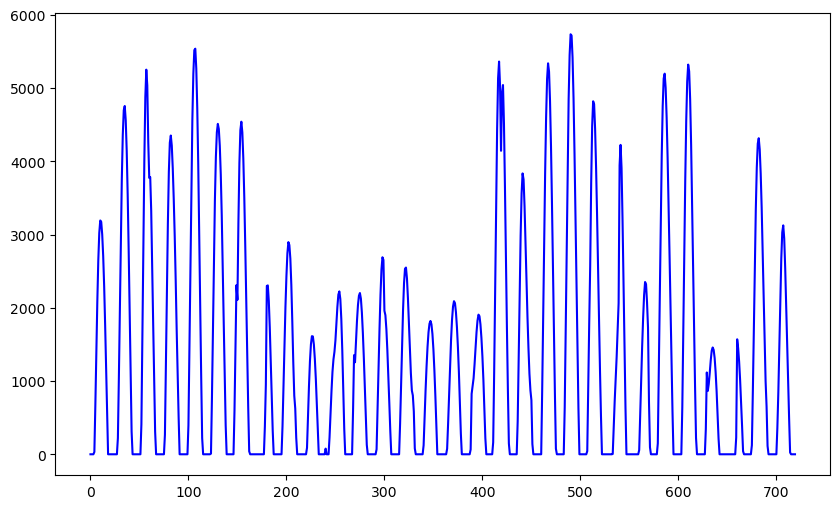

In [262]:
plt.figure(figsize=(10,6))
plt.plot(pred_a, color="blue")
plt.plot(pred_b, color="red")
plt.plot(pred_c, color="green")

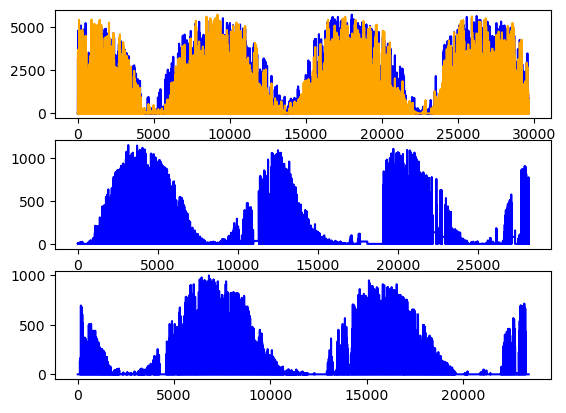

In [263]:

fig, axs = plt.subplots(3)

axs[0].plot(train_a_y.flatten() * a_max, color="blue")
axs[0].plot(pred_a_train, color="orange")

axs[1].plot(train_b_y.flatten() * b_max, color="blue")
axs[1].plot(pred_b_train, color="orange")

axs[2].plot(train_c_y.flatten() * c_max, color="blue")
axs[2].plot(pred_c_train, color="orange")

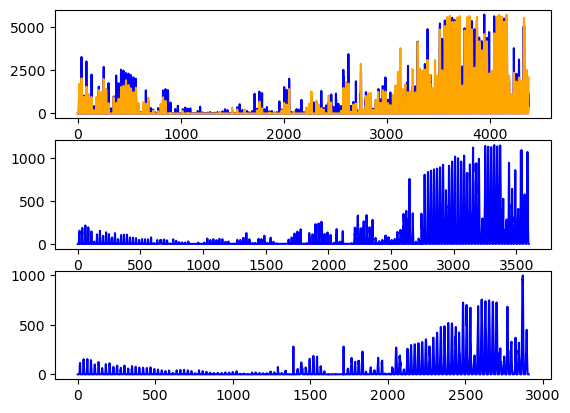

In [264]:
fig, axs = plt.subplots(3)

axs[0].plot(val_a_y.flatten() * a_max, color="blue")
axs[0].plot(pred_a_val, color="orange")

axs[1].plot(val_b_y.flatten() * b_max, color="blue")
axs[1].plot(pred_b_val, color="orange")

axs[2].plot(val_c_y.flatten() * c_max, color="blue")
axs[2].plot(pred_c_val, color="orange")

In [66]:
test = pd.read_csv('test.csv')

test

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0,A
1,1,2023-05-01 01:00:00,0,A
2,2,2023-05-01 02:00:00,0,A
3,3,2023-05-01 03:00:00,0,A
4,4,2023-05-01 04:00:00,0,A
...,...,...,...,...
2155,2155,2023-07-03 19:00:00,0,C
2156,2156,2023-07-03 20:00:00,0,C
2157,2157,2023-07-03 21:00:00,0,C
2158,2158,2023-07-03 22:00:00,0,C


In [67]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,id,prediction
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2155,2155,0
2156,2156,0
2157,2157,0
2158,2158,0


In [68]:
submit = np.concatenate((np.concatenate((preds_a, preds_b)),preds_c))

In [69]:
print(submit)

[ 2.72177    2.72177    2.7860198 ... -2.7149444 -1.1203444 -3.0022295]


In [71]:
from datetime import datetime

now = datetime.now() # current date and time

# Example, let the predictions be random values
test['prediction'] = submit
sample_submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv("xgboost_1.csv", index=False)